[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%205/5.7_ViT.ipynb)

In [ ]:
# 기본 설정 
import numpy as np
import tensorflow as tf

num_classes = 10
input_shape = (32, 32, 3)
learning_rate = 0.0001
batch_size = 64
epoch_num= 20
num_heads = 8
trans_num = 8
img_patch_size = 4
p_i_num=int(32*32/4/4)
proj_num=32
class_num =10

In [ ]:
# 데이터 다운로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 인코딩 값 정의
position_input = [range(64) for i in range(50000)]
position_input = np.array(position_input)
position_input = np.reshape(position_input, (50000,64,1))

# 모델 정의
i = tf.keras.Input(shape=input_shape)
p_i = tf.keras.Input(shape=(p_i_num,1))
out_patch = tf.image.extract_patches(images=i,
            sizes=[1, img_patch_size, img_patch_size, 1],
            strides=[1, img_patch_size, img_patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID")
out = tf.keras.layers.Reshape([-1,img_patch_size*img_patch_size*3])(out_patch)
p_out = tf.keras.layers.Embedding(p_i_num, proj_num)(p_i)
p_out = tf.keras.layers.Reshape([-1,proj_num])(p_out)
out = tf.keras.layers.Dense(proj_num)(out)
out = tf.keras.layers.Add()([out,p_out])

for _ in range(trans_num):
    out_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
    a_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, 
                                               key_dim=proj_num, 
                                               dropout=0.1)(out_1, out_1)
    out_2 = tf.keras.layers.Add()([a_out, out])
    out_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out_2)
    out_3 = tf.keras.layers.Dense(proj_num *2, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out_3 = tf.keras.layers.Dense(proj_num, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out = tf.keras.layers.Add()([out_3, out_2])

out = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(1024, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(512, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(class_num)(out)

vit_model = tf.keras.Model(inputs=[i,p_i], outputs=[out]) 

# 모델 요약
vit_model.summary()


170500096/170498071 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.extract_patches (TFOpL (None, 8, 8, 48)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 1)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 48)       0           tf.image.extract_patches[0][0]   
___________________________

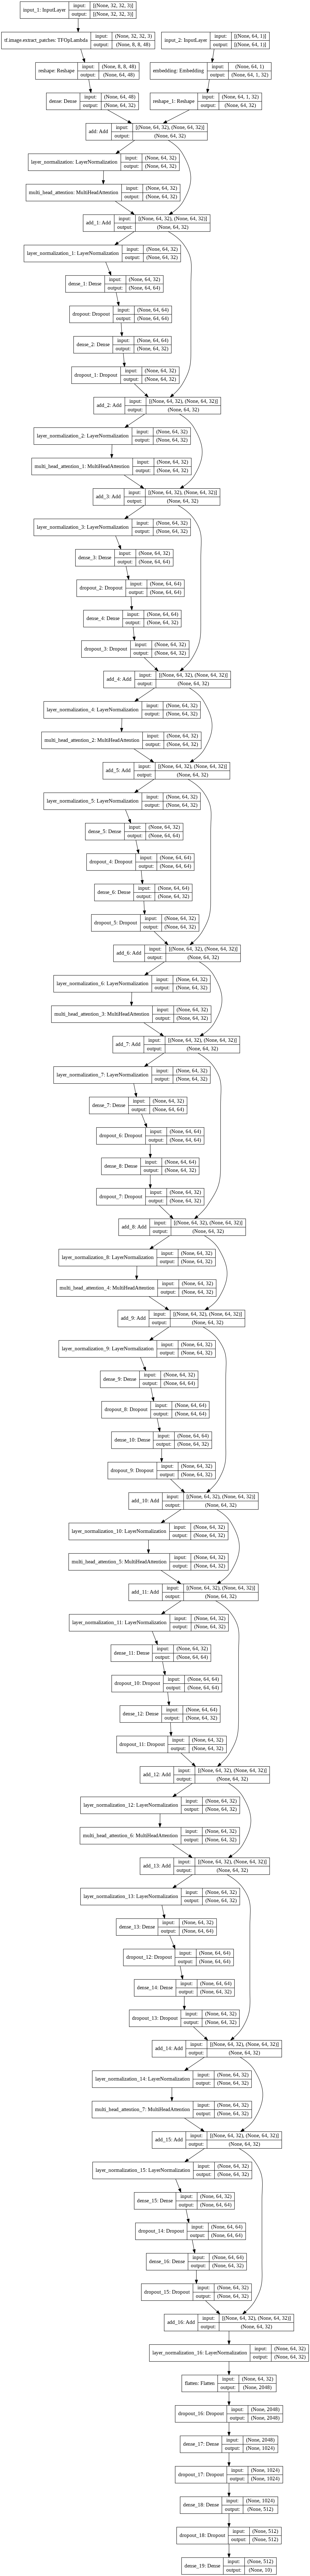

In [ ]:
# 모델 구조
tf.keras.utils.plot_model(vit_model,show_shapes=True)

In [ ]:
vit_image_model=  tf.keras.Model(inputs=vit_model.inputs, outputs=vit_model.layers[1].output)
img=vit_image_model.predict([x_train[0:2],position_input[0:2]])
img.shape

(2, 8, 8, 48)

(-0.5, 31.5, 31.5, -0.5)

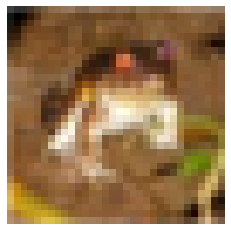

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

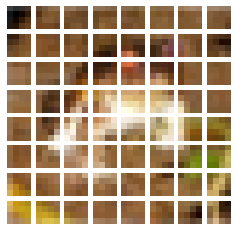

In [ ]:
plt.figure(figsize=(4, 4))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8 +j+1)
        sub_img=np.reshape(img[0,i,j,:],(4,4,3))
        plt.imshow(sub_img.astype("uint8"))
        plt.axis("off")

In [ ]:
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

vit_model.fit(x=[x_train,position_input],
              y=y_train,
              batch_size=batch_size,
              epochs=epoch_num,
              validation_split=0.3)

Epoch 1/20
547/547 [==============================] - 72s 109ms/step - loss: 2.2359 - accuracy: 0.2008 - top-5-accuracy: 0.6846 - val_loss: 1.9150 - val_accuracy: 0.2975 - val_top-5-accuracy: 0.8145
Epoch 2/20
547/547 [==============================] - 58s 106ms/step - loss: 1.7747 - accuracy: 0.3555 - top-5-accuracy: 0.8548 - val_loss: 1.6555 - val_accuracy: 0.4082 - val_top-5-accuracy: 0.8870
Epoch 3/20
547/547 [==============================] - 58s 106ms/step - loss: 1.5719 - accuracy: 0.4337 - top-5-accuracy: 0.8971 - val_loss: 1.5318 - val_accuracy: 0.4509 - val_top-5-accuracy: 0.9076
Epoch 4/20
547/547 [==============================] - 58s 105ms/step - loss: 1.4728 - accuracy: 0.4669 - top-5-accuracy: 0.9159 - val_loss: 1.4330 - val_accuracy: 0.4900 - val_top-5-accuracy: 0.9207
Epoch 5/20
547/547 [==============================] - 58s 106ms/step - loss: 1.3673 - accuracy: 0.5095 - top-5-accuracy: 0.9310 - val_loss: 1.3783 - val_accuracy: 0.5070 - val_top-5-accuracy: 0.9293
Epoch